## Import all required libraries

In [1]:
#DataFrame & Request libraries
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

#In case we need to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium

print('Libraries imported.')

Matplotlib version:  3.0.2
Libraries imported.


## Scrape website to get neighborhoods data in Bangkok

In [2]:
url = "http://www.geonames.org/postal-codes/TH/10/bangkok.html"

In [3]:
raw_postal_page = requests.get(url)
raw_postal_page

page = raw_postal_page.text
#page

In [4]:
#parse url into BeautifulSoup object
soup = BeautifulSoup(page)
print("Thai postal url parsed into bs object")

Thai postal url parsed into bs object


In [5]:
#print(soup.prettify())

## Parse Thai postal table into pandas DataFrame

In [6]:
table = soup.find("table",{"class":"restable"})

In [7]:
#for loop in table
l = []
for tr in table.find_all('tr'):
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
postal_df = pd.DataFrame(l, columns=['Test0', 'Place', 'Postal Code', 'Test1', 'Test2', 'Test3', 'Test4'])
postal_df.head()

,Test0,Place,Postal Code,Test1,Test2,Test3,Test4
0,None,None,None,None,None,None,None
1,1,Wattana,10110,Thailand,Bangkok,,
2,,13.708/100.456,None,None,None,None,None
3,2,Yannawa,10120,Thailand,Bangkok,,
4,,13.708/100.456,None,None,None,None,None


In [8]:
index_range = list(range(0,90,2))
index_range.append(89)
#index_range

In [9]:
postal_df_2 = postal_df.copy()

In [10]:
postal_df_2.drop(postal_df_2.index[index_range], inplace=True)
postal_df_2 = postal_df_2.reset_index(drop=True)
postal_df_2.head()

,Test0,Place,Postal Code,Test1,Test2,Test3,Test4
0,1,Wattana,10110,Thailand,Bangkok,,
1,2,Yannawa,10120,Thailand,Bangkok,,
2,3,Thawi Wattana,10170,Thailand,Bangkok,,
3,4,Pom Prap Sattru Phai,10100,Thailand,Bangkok,,
4,5,Samphanthawong,10100,Thailand,Bangkok,,


In [11]:
postal_df_2.drop(['Test0', 'Test1', 'Test2', 'Test3', 'Test4'], inplace=True, axis=1, errors='ignore')
postal_df_2 = postal_df_2.reset_index(drop=True)
postal_df_2.head()

,Place,Postal Code
0,Wattana,10110
1,Yannawa,10120
2,Thawi Wattana,10170
3,Pom Prap Sattru Phai,10100
4,Samphanthawong,10100


In [12]:
index_range_2 = list(range(1,90,2))
index_range_2.append(0)
index_range_2.sort()
#index_range_2

In [13]:
postal_df_3 = postal_df.copy()

In [14]:
postal_df_3.drop(postal_df_3.index[index_range_2], inplace=True)
postal_df_3 = postal_df_3.reset_index(drop=True)
postal_df_3.head()

,Test0,Place,Postal Code,Test1,Test2,Test3,Test4
0,,13.708/100.456,None,None,None,None,None
1,,13.708/100.456,None,None,None,None,None
2,,13.767/100.45,None,None,None,None,None
3,,13.733/100.5,None,None,None,None,None
4,,13.731/100.514,None,None,None,None,None


In [15]:
new = postal_df_3["Place"].str.split("/", n = 1, expand = True)
new.head()

,0,1
0,13.708,100.456
1,13.708,100.456
2,13.767,100.45
3,13.733,100.5
4,13.731,100.514


In [16]:
postal_df_merged = postal_df_2.copy()
postal_df_merged["Latitude"] = new[0]
postal_df_merged["Longitude"] = new[1]
postal_df_merged.head()

,Place,Postal Code,Latitude,Longitude
0,Wattana,10110,13.708,100.456
1,Yannawa,10120,13.708,100.456
2,Thawi Wattana,10170,13.767,100.45
3,Pom Prap Sattru Phai,10100,13.733,100.5
4,Samphanthawong,10100,13.731,100.514


In [17]:
#Convert string to float
postal_df_merged['Latitude'] = postal_df_merged['Latitude'].astype('float64')
postal_df_merged['Longitude'] = postal_df_merged['Longitude'].astype('float64')

In [18]:
#input Latitude and Longitude of Suanluang, Bangkok
#Refer from http://tha.postcodequery.com/MW8w.html

sl_latitude = 13.73529
sl_longitude = 100.62600
print('The geograpical coordinate of Suanluang, Bangkok are {}, {}.'.format(sl_latitude, sl_longitude))

The geograpical coordinate of Suanluang, Bangkok are 13.73529, 100.626.


## Create map of Suanluang, Bangkok with neighborhoods superimposed on top. (nearby postal code)

In [19]:
# create map of Suanluang using latitude and longitude values
map_suanluang = folium.Map(location=[sl_latitude, sl_longitude], zoom_start=11)

# add markers to map
for lat, lng, place, postalcode in zip(postal_df_merged['Latitude'], postal_df_merged['Longitude'], postal_df_merged['Place'], postal_df_merged['Postal Code']):
    label = '{}, {}'.format(place, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_suanluang)  
    
map_suanluang

## Define Foursquare credential and version

In [20]:
CLIENT_ID = 'R3FRLY1NKMVR0WPQTTHRUG30RVMATHRACJYMZ2D5CTGCHMA0' # your Foursquare ID
CLIENT_SECRET = 'IYQXWT3B1C3JXBENEVIJXZCRCHT0A0IDEBGWZISRI0UNNN1P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500
section = "coffee"

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R3FRLY1NKMVR0WPQTTHRUG30RVMATHRACJYMZ2D5CTGCHMA0
CLIENT_SECRET:IYQXWT3B1C3JXBENEVIJXZCRCHT0A0IDEBGWZISRI0UNNN1P


In [21]:
# create the API request URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        sl_latitude, 
        sl_longitude, 
        radius, 
        LIMIT,
        section)

In [25]:
results = requests.get(url).json()
#results

{'meta': {'code': 200, 'requestId': '5c8d26ea4c1f67470e73acac'},
 'response': {'headerLocation': 'Suan Luang',
  'headerFullLocation': 'Suan Luang, Bangkok',
  'headerLocationGranularity': 'neighborhood',
  'query': 'coffee',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 13.739790004500005,
    'lng': 100.63062382985808},
   'sw': {'lat': 13.730789995499997, 'lng': 100.62137617014193}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ca5ed0ea6e08cfa315f7594',
       'name': 'ชาชัก พัฒนาการ40',
       'location': {'address': 'พัฒนาการ40',
        'lat': 13.73612423344085,
        'lng': 100.62630454460545,
        'labeledLatLngs': [{'label': 'display',
          'lat': 13.73612423344085,
          'lng': 100.62630454460545}],
        'distance': 98,
        '

In [26]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [27]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,ชาชัก พัฒนาการ40,Café,13.736124,100.626305
1,Tea'R us,Café,13.737382,100.626745
2,Inthanin (อินทนิล),Coffee Shop,13.736469,100.623257
3,TrueCoffee (ทรูคอฟฟี่),Coffee Shop,13.736619,100.622289
4,ร้านพ้องเพื่อน,Coffee Shop,13.737342,100.626004
5,block 37 cafe,Café,13.737343,100.626633
6,หวานเจ็บอก,Café,13.737854,100.627384
7,Billion Coffee (บิลเลี่ยน คอฟฟี่),Coffee Shop,13.736818,100.622755


In [28]:
nearby_venues.shape

(8, 4)

## Explore coffee shops around Bangkok

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            section)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Place', 
                  'Place Latitude', 
                  'Place Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
bangkok_venues = getNearbyVenues(names=postal_df_merged['Place'],
                                   latitudes=postal_df_merged['Latitude'],
                                   longitudes=postal_df_merged['Longitude']
                                  )

Wattana
Yannawa
Thawi Wattana
Pom Prap Sattru Phai
Samphanthawong
Bang Kholame
Thung Khru
Rat Burana
Bang Bon
Bang Khun Thian
Nong Khaem
Phasi Charoen
Bang Khae
Taling Chan
Phra Nakhon
Lak Si
Sai Mai
Bang Khen
Khanna Yao
Lat Phrao
Saphan Sung B39
Bung Kum
Pra Vet
Suang Luang
Phra Khanong
Dusit
Wangthong Lang
Huai Khwang
Pahtum Wan
Ding Daeng
Bang Rak
Khlong Samwa
Min Buri
Lat Krabang
Nong Chok
Bangkok Yai
Khlong San
Thon Buri
Bang Plat
Bangkok Noi
Bang Su
Bang Kapi
Bang Na
Phaya Thai


In [31]:
#Check the size of resulting dataframe
print(bangkok_venues.shape)
bangkok_venues.head()

(317, 7)


,Place,Place Latitude,Place Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wattana,13.708,100.456,Starbucks (สตาร์บัคส์),13.709113,100.452060,Coffee Shop
1,Wattana,13.708,100.456,Serie 5 Coffee,13.711062,100.456096,Coffee Shop
2,Wattana,13.708,100.456,Studio Cafe',13.711620,100.456978,Coffee Shop
3,Wattana,13.708,100.456,SumMer Mood Ice Cream Cafe,13.709597,100.451845,Café
4,Yannawa,13.708,100.456,Starbucks (สตาร์บัคส์),13.709113,100.452060,Coffee Shop


In [32]:
bangkok_venues

,Place,Place Latitude,Place Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wattana,13.708,100.456,Starbucks (สตาร์บัคส์),13.709113,100.452060,Coffee Shop
1,Wattana,13.708,100.456,Serie 5 Coffee,13.711062,100.456096,Coffee Shop
2,Wattana,13.708,100.456,Studio Cafe',13.711620,100.456978,Coffee Shop
3,Wattana,13.708,100.456,SumMer Mood Ice Cream Cafe,13.709597,100.451845,Café
4,Yannawa,13.708,100.456,Starbucks (สตาร์บัคส์),13.709113,100.452060,Coffee Shop
5,Yannawa,13.708,100.456,Serie 5 Coffee,13.711062,100.456096,Coffee Shop
6,Yannawa,13.708,100.456,Studio Cafe',13.711620,100.456978,Coffee Shop
7,Yannawa,13.708,100.456,SumMer Mood Ice Cream Cafe,13.709597,100.451845,Café
8,Thawi Wattana,13.767,100.450,สตาร์บัค,13.768701,100.452690,Coffee Shop
9,Pom Prap Sattru Phai,13.733,100.500,First Cup Coffee (Masterview Executive Place),13.732275,100.502209,Coffee Shop


## Check how many coffee shops or cafe were returned for each place

In [33]:
bangkok_venues_count = bangkok_venues.groupby('Place').count()
bangkok_venues_count.drop(['Place Latitude', 'Place Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], inplace=True, axis=1, errors='ignore')
bangkok_venues_count = bangkok_venues_count.sort_values(by=['Venue'],ascending=False)
bangkok_venues_count = bangkok_venues_count.rename(index=str,columns={"Venue":"Number of Coffee Shops"})
bangkok_venues_count.head()

,Number of Coffee Shops
Place,
Phra Nakhon,27
Samphanthawong,18
Bang Khun Thian,15
Huai Khwang,14
Wangthong Lang,14


## Visualize in bar chart

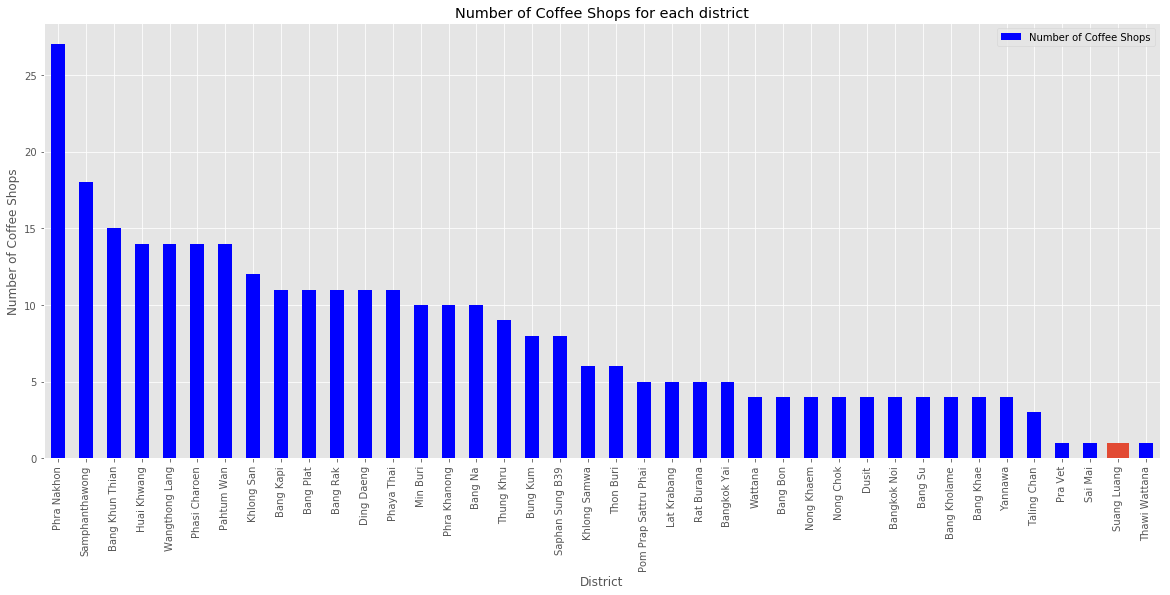

In [51]:
bangkok_venues_count.plot(kind="bar", figsize=(20, 8), color="blue")

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Number of Coffee Shops') # add y-label to the plot
plt.title('Number of Coffee Shops for each district') # add title to the plot

plt.bar([38], [1]) #add color for Suanluang bar

plt.show()

## <font color=red>Analysis</font>
### We found that lots of coffee shops are in 'Phra Nakhon' district, 'Samphanthawong' district, and other districts
### Luckily our district has only 1 coffee shop according to data provided from Foursquare

## Analyze each neighborhood

In [35]:
# create map
map_final = folium.Map(location=[sl_latitude, sl_longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, venue in zip(bangkok_venues['Venue Latitude'], bangkok_venues['Venue Longitude'], bangkok_venues['Venue']):
    label = folium.Popup(str(venue), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2.5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7).add_to(map_final)
       
map_final

In [36]:
# one hot encoding
bangkok_onehot = pd.get_dummies(bangkok_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangkok_onehot['Place'] = bangkok_venues['Place'] 

# move neighborhood column to the first column
fixed_columns = [bangkok_onehot.columns[-1]] + list(bangkok_onehot.columns[:-1])
bangkok_onehot = bangkok_onehot[fixed_columns]

bangkok_onehot.head()

,Place,Art Gallery,Arts & Crafts Store,Bakery,Bookstore,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,Dive Spot,Donut Shop,Fast Food Restaurant,Japanese Restaurant,Juice Bar,Photography Studio,Restaurant,Tea Room,Thai Restaurant
0,Wattana,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Wattana,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Wattana,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Wattana,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,Yannawa,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [37]:
#group rows by place and by taking the mean of the frequency of occurrence of each category
bangkok_grouped = bangkok_onehot.groupby('Place').mean().reset_index()
bangkok_grouped

,Place,Art Gallery,Arts & Crafts Store,Bakery,Bookstore,Café,Chinese Restaurant,Coffee Shop,Dessert Shop,Dive Spot,Donut Shop,Fast Food Restaurant,Japanese Restaurant,Juice Bar,Photography Studio,Restaurant,Tea Room,Thai Restaurant
0,Bang Bon,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,Bang Kapi,0.000000,0.000000,0.000000,0.000000,0.272727,0.000000,0.727273,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,Bang Khae,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,Bang Kholame,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,Bang Khun Thian,0.000000,0.000000,0.000000,0.000000,0.266667,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.066667,0.0,0.066667
5,Bang Na,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,Bang Plat,0.000000,0.000000,0.000000,0.000000,0.454545,0.000000,0.454545,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.0,0.000000,0.0,0.000000
7,Bang Rak,0.090909,0.000000,0.000000,0.000000,0.363636,0.000000,0.545455,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,Bang Su,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,Bangkok Noi,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


In [38]:
#Write function to sort
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Place']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
places_venues_sorted = pd.DataFrame(columns=columns)
places_venues_sorted['Place'] = bangkok_grouped['Place']

for ind in np.arange(bangkok_grouped.shape[0]):
    places_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangkok_grouped.iloc[ind, :], num_top_venues)

places_venues_sorted

,Place,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bang Bon,Café,Coffee Shop,Thai Restaurant
1,Bang Kapi,Coffee Shop,Café,Thai Restaurant
2,Bang Khae,Café,Coffee Shop,Thai Restaurant
3,Bang Kholame,Coffee Shop,Café,Thai Restaurant
4,Bang Khun Thian,Coffee Shop,Café,Thai Restaurant
5,Bang Na,Coffee Shop,Café,Thai Restaurant
6,Bang Plat,Café,Coffee Shop,Juice Bar
7,Bang Rak,Coffee Shop,Café,Art Gallery
8,Bang Su,Café,Coffee Shop,Thai Restaurant
9,Bangkok Noi,Coffee Shop,Arts & Crafts Store,Café


## Cluster Places

In [40]:
# set number of clusters
kclusters = 5

bangkok_grouped_clustering = bangkok_grouped.drop('Place', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangkok_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 2, 1, 1, 2, 2, 2, 0, 2], dtype=int32)

In [41]:
# add clustering labels
places_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangkok_merged = postal_df_merged.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangkok_merged = bangkok_merged.join(places_venues_sorted.set_index('Place'), on='Place')
bangkok_merged = bangkok_merged.join(bangkok_venues_count, on='Place')

bangkok_merged.head() # check the last columns!

,Place,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Number of Coffee Shops
0,Wattana,10110,13.708,100.456,1.0,Coffee Shop,Café,Thai Restaurant,4.0
1,Yannawa,10120,13.708,100.456,1.0,Coffee Shop,Café,Thai Restaurant,4.0
2,Thawi Wattana,10170,13.767,100.450,3.0,Coffee Shop,Thai Restaurant,Dessert Shop,1.0
3,Pom Prap Sattru Phai,10100,13.733,100.500,1.0,Coffee Shop,Café,Thai Restaurant,5.0
4,Samphanthawong,10100,13.731,100.514,2.0,Café,Coffee Shop,Dive Spot,18.0


In [42]:
bangkok_merged_final = bangkok_merged.copy()

In [43]:
#bangkok_merged_final['Cluster Labels']
bangkok_merged_final.dropna(inplace=True)
bangkok_merged_final['Cluster Labels'] = bangkok_merged_final['Cluster Labels'].astype(int)

In [44]:
# create map
map_clusters = folium.Map(location=[sl_latitude, sl_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangkok_merged_final['Latitude'], bangkok_merged_final['Longitude'], bangkok_merged_final['Place'], bangkok_merged_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [45]:
#Cluster 1
bangkok_merged_final.loc[bangkok_merged_final['Cluster Labels'] == 0, bangkok_merged_final.columns[[0] + [1] + list(range(5, bangkok_merged_final.shape[1]))]]

,Place,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Number of Coffee Shops
7,Rat Burana,10140,Café,Coffee Shop,Thai Restaurant,5.0
8,Bang Bon,10150,Café,Coffee Shop,Thai Restaurant,4.0
14,Phra Nakhon,10200,Café,Coffee Shop,Dessert Shop,27.0
33,Lat Krabang,10520,Café,Coffee Shop,Tea Room,5.0
36,Khlong San,10600,Café,Coffee Shop,Dive Spot,12.0
37,Thon Buri,10600,Café,Coffee Shop,Thai Restaurant,6.0
40,Bang Su,10800,Café,Coffee Shop,Thai Restaurant,4.0


In [46]:
#Cluster 2
bangkok_merged_final.loc[bangkok_merged_final['Cluster Labels'] == 1, bangkok_merged_final.columns[[0] + [1] + list(range(5, bangkok_merged_final.shape[1]))]]

,Place,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Number of Coffee Shops
0,Wattana,10110,Coffee Shop,Café,Thai Restaurant,4.0
1,Yannawa,10120,Coffee Shop,Café,Thai Restaurant,4.0
3,Pom Prap Sattru Phai,10100,Coffee Shop,Café,Thai Restaurant,5.0
5,Bang Kholame,10120,Coffee Shop,Café,Thai Restaurant,4.0
6,Thung Khru,10140,Coffee Shop,Café,Donut Shop,9.0
9,Bang Khun Thian,10150,Coffee Shop,Café,Thai Restaurant,15.0
11,Phasi Charoen,10160,Coffee Shop,Donut Shop,Dessert Shop,14.0
20,Saphan Sung B39,10240,Coffee Shop,Café,Thai Restaurant,8.0
21,Bung Kum,10240,Coffee Shop,Café,Thai Restaurant,8.0
26,Wangthong Lang,10310,Coffee Shop,Café,Thai Restaurant,14.0


In [47]:
#Cluster 3
bangkok_merged_final.loc[bangkok_merged_final['Cluster Labels'] == 2, bangkok_merged_final.columns[[0] + [1] + list(range(5, bangkok_merged_final.shape[1]))]]

,Place,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Number of Coffee Shops
4,Samphanthawong,10100,Café,Coffee Shop,Dive Spot,18.0
12,Bang Khae,10160,Café,Coffee Shop,Thai Restaurant,4.0
24,Phra Khanong,10260,Coffee Shop,Café,Japanese Restaurant,10.0
29,Ding Daeng,10400,Coffee Shop,Café,Thai Restaurant,11.0
30,Bang Rak,10500,Coffee Shop,Café,Art Gallery,11.0
32,Min Buri,10510,Coffee Shop,Café,Tea Room,10.0
38,Bang Plat,10700,Café,Coffee Shop,Juice Bar,11.0
39,Bangkok Noi,10700,Coffee Shop,Arts & Crafts Store,Café,4.0
42,Bang Na,10260,Coffee Shop,Café,Thai Restaurant,10.0
43,Phaya Thai,10400,Coffee Shop,Café,Thai Restaurant,11.0


In [48]:
#Cluster 4
bangkok_merged_final.loc[bangkok_merged_final['Cluster Labels'] == 3, bangkok_merged_final.columns[[0] + [1] + list(range(5, bangkok_merged_final.shape[1]))]]

,Place,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Number of Coffee Shops
2,Thawi Wattana,10170,Coffee Shop,Thai Restaurant,Dessert Shop,1.0
10,Nong Khaem,10160,Coffee Shop,Thai Restaurant,Dessert Shop,4.0
13,Taling Chan,10170,Coffee Shop,Thai Restaurant,Dessert Shop,3.0
16,Sai Mai,10220,Coffee Shop,Thai Restaurant,Dessert Shop,1.0
25,Dusit,10300,Coffee Shop,Thai Restaurant,Dessert Shop,4.0
31,Khlong Samwa,10510,Coffee Shop,Thai Restaurant,Dessert Shop,6.0
35,Bangkok Yai,10600,Coffee Shop,Photography Studio,Thai Restaurant,5.0


In [49]:
#Cluster 5
bangkok_merged_final.loc[bangkok_merged_final['Cluster Labels'] == 4, bangkok_merged_final.columns[[0] + [1] + list(range(5, bangkok_merged_final.shape[1]))]]

,Place,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Number of Coffee Shops
22,Pra Vet,10250,Café,Thai Restaurant,Dessert Shop,1.0
23,Suang Luang,10250,Café,Thai Restaurant,Dessert Shop,1.0


## <font color=red>Analysis</font>

### Cluster 1 | High number of Cafe(s)
### Cluster 2 | High number of Coffee Shops
### Cluster 3 | Average number of Coffee Shops and Cafe(s)
### Cluster 4 | Low number of Coffee Shops
### Cluster 5 | Low number of Cafe(s) <<- Our district is in this cluster


<br><br><br>

## <font color=red>Conclusion</font>

### We can suggest our family that they are <font color=green>able</font> to open a new coffee shop in our district (Suanluang) because there are still low number of competitors.
<br>
<br>

### In addition, if they want to open in other districts in Bangkok that is not Suanluang they can consider districts in <font color=blue>Cluster 3</font> and <font color=blue>Cluster 4</font> because these districts also still have low number of coffee shops or cafes located around them.